# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [42]:
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [43]:
from PyPDF2 import PdfReader
import os
from dotenv import load_dotenv

load_dotenv()
key = os.getenv("GOOGLE_API_KEY")
pdf_path1 = "data/asthma-diagnosis-monitoring-and-chronic-asthma-management.pdf"
pdf_path2 = "data/hypertension-in-adults-diagnosis-and-management.pdf"

with open(pdf_path1, "rb") as file:
    reader = PdfReader(file)
     # Extract text from all pages in the PDF
    text1 = "".join(page.extract_text() for page in reader.pages if page.extract_text())
    
with open(pdf_path2, "rb") as file:
    reader = PdfReader(file)
     # Extract text from all pages in the PDF
    text2 = "".join(page.extract_text() for page in reader.pages if page.extract_text())
    
# Display the extracted text
combined_text = text1 + "\n\n" + text2

combined_text

"Asthma: diagnosis, \nmoni toring and chr onic \nasthma manag emen t (BTS, \nNICE, SI GN) \nNICE guideline \nPublished: 27 No vember 202 4 \nwww .nice.or g.uk/guidance/ng2 45 \n© NICE 202 4. All right s reserved. Subject t o Notice of right s (https://www .nice.or g.uk/t erms-and-\nconditions#notice-of -right s).Your r esponsi bility \nThe r ecommendations in t his guideline r epresent t he view of NICE, arriv ed at aft er car eful \nconsideration of t he evidence a vailable. When e xercising t heir judgement, pr ofessionals \nand practitioners ar e expect ed to tak e this guideline fully int o account, alongside t he \nindividual needs, pr eferences and v alues of t heir patient s or t he people using t heir ser vice. \nIt is not mandat ory to apply t he recommendations, and t he guideline does not o verride t he \nresponsibility t o mak e decisions appr opriat e to the cir cumstances of t he individual, in \nconsultation wit h them and t heir f amilies and car ers or guar dian. \nAll

"""
## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.
"""

In [44]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
# Initialize a text splitter with specified chunk size and overlap
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(combined_text)

# Display the resulting chunks
chunks


['Asthma: diagnosis, \nmoni toring and chr onic \nasthma manag emen t (BTS, \nNICE, SI GN) \nNICE guideline \nPublished: 27 No vember 202 4 \nwww .nice.or g.uk/guidance/ng2 45 \n© NICE 202 4. All right s reserved. Subject t o Notice of right s (https://www .nice.or g.uk/t erms-and-\nconditions#notice-of -right s).Your r esponsi bility \nThe r ecommendations in t his guideline r epresent t he view of NICE, arriv ed at aft er car eful \nconsideration of t he evidence a vailable. When e xercising t heir judgement, pr ofessionals \nand practitioners ar e expect ed to tak e this guideline fully int o account, alongside t he \nindividual needs, pr eferences and v alues of t heir patient s or t he people using t heir ser vice. \nIt is not mandat ory to apply t he recommendations, and t he guideline does not o verride t he \nresponsibility t o mak e decisions appr opriat e to the cir cumstances of t he individual, in \nconsultation wit h them and t heir f amilies and car ers or guar dian. \nAl

In [45]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 130
Preview of the first chunk: Asthma: diagnosis, 
moni toring and chr onic 
asthma manag emen t (BTS, 
NICE, SI GN) 
NICE guideline 
Published: 27 No vember 202 4 
www .nice.or g.uk/guidance/ng2 45 
© NICE 202 4. All right s reser


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model.

In [46]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [47]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 636
Asthma: diagnosis, moni toring and chr onic asthma manag emen t (BTS, NICE, SI GN) NICE guideline Published: 27 No vember 202 4 www .nice.or g.uk/guidance/ng2 45 © NICE 202 4. All right s reserved. Subject t o Notice of right s (https://www .nice.or g.uk/t erms-and- conditions#notice-of -right s).Your r esponsi bility The r ecommendations in t his guide


In [ ]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁As', 'th', 'ma', ':', '▁', 'diagnos', 'is', ',', '▁moni', '▁to', 'ring', '▁and', '▁chr', '▁on', 'ic', '▁as', 'th', 'ma', '▁mana', 'g', '▁em', 'en', '▁t', '▁(', 'B', 'TS', ',', '▁', 'NICE', ',', '▁SI', '▁', 'GN', ')', '▁', 'NICE', '▁guide', 'line', '▁Published', ':', '▁27', '▁No', '▁v', 'ember', '▁202', '▁4', '▁www', '▁', '.', 'nice', '.', 'or', '▁g', '.', 'uk', '/', 'gui', 'dan', 'ce', '/', 'ng', '2', '▁45', '▁©', '▁', 'NICE', '▁202', '▁4.', '▁All', '▁right', '▁s', '▁reserved', '.', '▁Subject', '▁t', '▁o', '▁No', 'tice', '▁of', '▁right', '▁s', '▁(', 'https', '://', 'www', '▁', '.', 'nice', '.', 'or', '▁g', '.', 'uk', '/', 't', '▁er', 'ms', '-', 'and', '-', '▁conditions', '#', 'no', 'tice', '-', 'of', '▁-', 'right', '▁s', ').', 'You', 'r', '▁r', '▁e', 'spon', 'si', '▁', 'bility', '▁The', '▁r', '▁e', 'com', 'mend', 'ations', '▁in', '▁t', '</s>']
Chunk 1: ['<s>', '▁line', '▁r', '▁e', 'present', '▁t', '▁he', '▁view', '▁of', '▁', 'NICE', ',', '▁arri', 'v', '▁ed', '▁at', '

: 

In [ ]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

/tmp/ipykernel_9576/4090508586.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


"""
## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.
"""

In [ ]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [ ]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 636


In [ ]:
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(token_split_texts, f)

In [ ]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

636
636


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [ ]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/636 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/636 [00:01<19:34,  1.85s/it]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/si

Projected dataset embeddings shape: (636, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [ ]:
def retrieve(query, k):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [ ]:
query = "what is the most important factor in diagnosing asthma"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
en ag ed 5 to 11 Recommendation 1 .8.1 Asthma: diagnosis, monit oring and chr onic ast hma management (BTS, NICE, SIGN) (NG2 45)


In [ ]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings: 100%|██████████| 1/1 [00:00<0

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

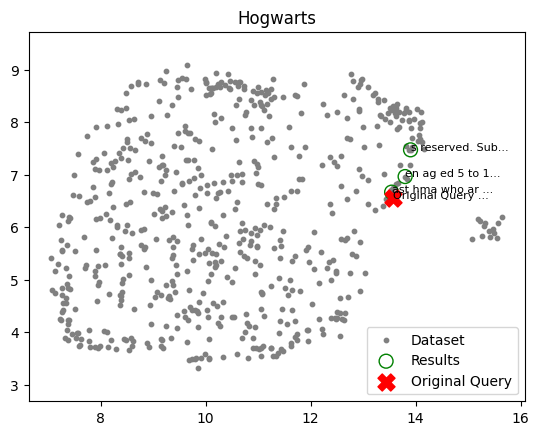

In [ ]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Original Query Text'  # Replace with your actual query text if needed
plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Hogwarts')
plt.legend()
plt.show()


## Attach Retrieved Results to LLM

- Combine learnings from week 1 with approach from this week to inject your data into prompts and create a simple question answering system

In [ ]:
from transformers import pipeline

# Beispiel für abgerufene Ergebnisse
retrieved_results = [
    "Python ist eine Programmiersprache, die für ihre Einfachheit bekannt ist.",
    "Maschinelles Lernen ist ein Teilgebiet der künstlichen Intelligenz.",
    "Ein neuronales Netzwerk ist ein Modell, das von der Struktur des menschlichen Gehirns inspiriert ist."
]

# Kombiniere die abgerufenen Ergebnisse in einen einzigen Textblock
context = "\n".join(retrieved_results)

# Initialisiere ein vortrainiertes Frage-Antwort-Modell
qa_pipeline = pipeline("question-answering")

# Beispiel-Frage
question = "Was ist Maschinelles Lernen?"

# Führe die Frage-Antwort-Pipeline aus
result = qa_pipeline(question=question, context=context)

# Ausgabe der Antwort
print(f"Frage: {question}")
print(f"Antwort: {result['answer']}")